In [1]:
import sys
import os
from torch.utils.data import DataLoader
import torch
from definitions import ROOT_DIR, MODEL

# Add src directory to sys.path
# Adapted from Taras Alenin's answer on StackOverflow at:
# https://stackoverflow.com/a/55623567
src_path = os.path.join(ROOT_DIR, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import custom modules
from prototype import SiameseBERT, ContrastiveLoss  # noqa: E402
import dataset  # noqa: E402

# Try to use machines parallelism by setting env variable
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [2]:
#############################################################################
# CONSTANTS
#############################################################################

# Learning rate of 2e-05 as per Ibrahim Et. Al (2023) [13:10]
# This is intentionally very small as we are fine-tuning a pre-trained model
LEARNING_RATE = 2e-05


In [3]:
#############################################################################
# MODEL INSTANTIATION
#############################################################################

# Instantiate custom Siamese SBERT model
model = SiameseBERT(MODEL)

# Instantiate custom contrastive loss function
# TODO: Consider implementing 'modified contrastive loss' from
# https://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf [18]
# and
# Tyo Et. Al (2021) [15]
loss_function = ContrastiveLoss(margin=10.0)

# Instantiate Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [4]:
#############################################################################
# DATASET/LOADER INSTANTIATION
#############################################################################

train_ds = dataset.CustomDataset('data/cleaned', evaluate=False)


Token indices sequence length is longer than the specified maximum sequence length for this model (357538 > 512). Running this sequence through the model will result in indexing errors


In [5]:
dataloader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=dataset.collate_fn
)

In [6]:
#############################################################################
# TRAINING
#############################################################################

# Collate labels tensor, preserving ordering relative to input ids and
# attention masks.
train_labels = torch.Tensor([])
losses = []

for batch_a, batch_b, labels in dataloader:
    train_labels = torch.cat([train_labels, labels])
    u, v = model(
        batch_a['input_ids'], 
        batch_a['attention_mask'],
        batch_b['input_ids'], 
        batch_b['attention_mask']
    )
    loss = loss_function(u, v, labels)
    losses.append(loss)

    # Clear out any existing gradients
    optimizer.zero_grad()

    # Backpropogation pass
    loss.backward()

    # Update weights using calculated gradients from Adam optimizer
    optimizer.step()

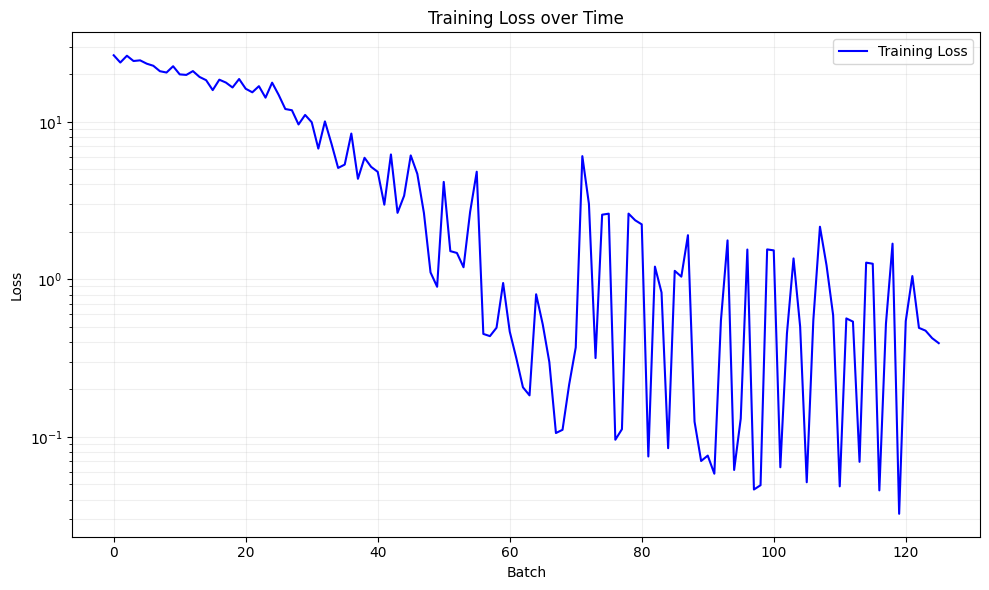

In [8]:
import matplotlib.pyplot as plt
import torch

# Convert list of tensors to regular numbers
losses_plain = [tensor.item() for tensor in losses]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(losses_plain, 'b-', label='Training Loss')
plt.grid(True)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.legend()

plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
#############################################################################
# DATASET/LOADER INSTANTIATION
#############################################################################

eval_ds = dataset.CustomDataset('data/cleaned', evaluate=True)


Token indices sequence length is longer than the specified maximum sequence length for this model (357538 > 512). Running this sequence through the model will result in indexing errors


In [10]:
eval_dataloader = DataLoader(
    eval_ds,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=dataset.collate_fn
)

In [11]:
#############################################################################
# INFERENCE
#############################################################################

# Set model to evaluation mode
model.eval()

# Collate labels tensor, preserving ordering relative to input ids and
# attention masks.
ground_truths = torch.Tensor([])
pred_probs = torch.Tensor([])

# Run inference
with torch.no_grad():  # Disable gradient calculation for inference
    for batch_a, batch_b, labels in eval_dataloader:
        ground_truths = torch.cat([ground_truths, labels])
        # Forward pass through the model
        u_inference, v_inference = model(batch_a['input_ids'], 
                                         batch_a['attention_mask'],
                                         batch_b['input_ids'], 
                                         batch_b['attention_mask'])

        # Calculate cosine similarity between embeddings
        similarities = torch.nn.functional.cosine_similarity(u_inference,
                                                             v_inference)

        # Scale similarities from [-1,1] to [0,1] range
        scaled_similarities = (similarities + 1) / 2

        # Add scaled similarities to pred_probs
        pred_probs = torch.cat([pred_probs, scaled_similarities])


In [12]:
preds = pred_probs.round()

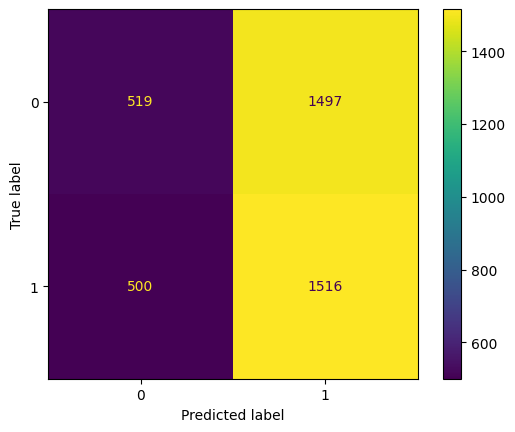

In [13]:
# Adapted from:
# https://www.w3schools.com/python/python_ml_confusion_matrix.asp
# Accessed 2024-12-14
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(ground_truths, preds)

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix,
    display_labels = [0, 1])

cm_display.plot()
plt.show()

In [14]:
ground_truths[0:10]

tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0.])

In [15]:
pred_probs[0:10]

tensor([0.9694, 0.9956, 0.3478, 0.2843, 0.9892, 0.5427, 0.4281, 0.5238, 0.5099,
        0.4158])

In [16]:
pred_probs.mean()

tensor(0.6773)

In [17]:
preds[0:10]

tensor([1., 1., 0., 0., 1., 1., 0., 1., 1., 0.])

In [18]:
ground_truths.type(torch.int64).bincount()

tensor([2016, 2016])

In [19]:
preds.type(torch.int64).bincount()

tensor([1019, 3013])

In [20]:
c = 0
for i in range(64):
    for j in range(i + 1, 64):
        c += 1
print(c)

2016


In [24]:
len(train_ds._A_chunks) + len(train_ds._notA_chunks)

127

In [25]:
2016/32

63.0